<a href="https://colab.research.google.com/github/schmuecker/machine-learning-course/blob/main/02%20linear%20regression%20eigengesichtern%20naive%20bayes/02.1%20linear%20regression/02.1_Linear_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Arbeitsblatt 2: Lineare Regression, Eigengesichter und Bayes-Klassifikator

## 1. Linear Regression on Fish Data

The following data-set contains the number of fish groups of camper caught in a state park (taken from https://stats.idre.ucla.edu/r/dae/zip/). Your task here is to predict the number of fish caught by a fishing party from the following information: 

* how many people are in the group
* the number children in the group
* the use of live bait
* whether the group came with a camper to the park. 

We have a small data set, of 250 groups, which visited a state park and provided. For comparison the data set is already split into a training set and testset.

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# The Fish Data Set
# See example 2 from https://stats.idre.ucla.edu/r/dae/zip/ 
#"nofish","livebait","camper","persons","child","xb","zg","count"
import os
from urllib.request import urlretrieve
if not os.path.isfile('fishing.npz'):
    print("Downloading")
    urlretrieve('http://www-home.htwg-konstanz.de/~oduerr/data/fishing.npz',filename = 'fishing.npz')
d = np.load('fishing.npz')

Xt = d['Xt'] #"livebait","camper","persons","child"
Xte = d['Xte']
yt = d['yt']
yte = d['yte']

df_t = pd.DataFrame(Xt)
df_t.insert(0, 'Intercept',np.ones((200,1)))
print('training set')
print(df_t.describe())

df_te = pd.DataFrame(Xte)
df_te.insert(0, 'Intercept',np.ones((50,1)))
print('test set')
print(df_te.describe())

Downloading
training set
       Intercept           0           1           2           3
count      200.0  200.000000  200.000000  200.000000  200.000000
mean         1.0    0.855000    0.600000    2.540000    0.705000
std          0.0    0.352984    0.491127    1.133501    0.889907
min          1.0    0.000000    0.000000    1.000000    0.000000
25%          1.0    1.000000    0.000000    2.000000    0.000000
50%          1.0    1.000000    1.000000    3.000000    0.000000
75%          1.0    1.000000    1.000000    4.000000    1.000000
max          1.0    1.000000    1.000000    4.000000    3.000000
test set
       Intercept          0          1          2          3
count       50.0  50.000000  50.000000  50.000000  50.000000
mean         1.0   0.900000   0.540000   2.480000   0.600000
std          0.0   0.303046   0.503458   1.034901   0.670059
min          1.0   0.000000   0.000000   1.000000   0.000000
25%          1.0   1.000000   0.000000   2.000000   0.000000
50%          1.

In [3]:
pd.DataFrame(yt).describe()

,0
count,200.000000
mean,3.355000
std,11.984872
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,149.000000


a) Do a linear regression by creating a design matrix with the intercept term and use the fomulae given in the lecture to determine the coefficients on the training set.

In [4]:

y = np.asmatrix(yt)[0].T
X = np.asmatrix(df_t.iloc[:,0:5])
N = y.shape[0] #200
print(X[0:5])
y.shape, X.shape

[[1. 1. 0. 4. 0.]
 [1. 1. 1. 2. 0.]
 [1. 1. 1. 3. 0.]
 [1. 1. 1. 3. 2.]
 [1. 1. 1. 4. 1.]]


((200, 1), (200, 5))

In [5]:
w = np.ones((5)) #Setting w = 1 just for demonstration w is not trained
d = np.matmul(X,w)
d[:,1:10]

matrix([[5., 6., 8., 8., 3., 6., 5., 8., 6.]])

**"By Hand"**

In [6]:
XTX = np.matmul(X.T,X)
XTXI = np.linalg.inv(XTX)
XTXIXT = np.matmul(XTXI, X.T)
w = np.matmul(XTXIXT,y)
w

matrix([[-8.49222821],
        [ 2.4822138 ],
        [ 2.95430727],
        [ 4.64953914],
        [-5.47160051]])

In [7]:
np.mean(np.square((np.matmul(X,w).flatten() - y.flatten()))) # The MSE

117.26947782687193

117.26947782687193

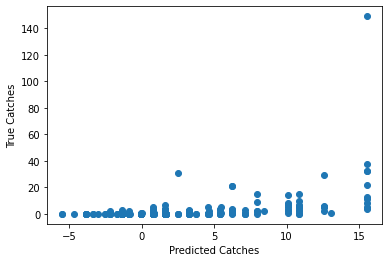

In [8]:
y_pred = np.matmul(X,w)
plt.scatter([y_pred[:,0]], [y[:,0]])
plt.xlabel('Predicted Catches')
plt.ylabel('True Catches')

np.mean(np.square((y_pred[:,0] - y[:,0]))) # The MSE

b) Repeat a) but this time with `LinearRegression` from `sklearn.linear_model`

**Using sklearn**

In [9]:
from sklearn.linear_model import LinearRegression
model_skl = LinearRegression(fit_intercept=False) #We have an extended X
model_skl.fit(X,y)
model_skl.coef_

array([[-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051]])

Result: array([-8.49222821,  2.4822138 ,  2.95430727,  4.64953914, -5.47160051])
Don't forget the intercept, you should have 5 numbers!

c) Determine the Root Mean Square Error (RMSE) and the average negative log-likelihood (NLL) on the testset. For NLL we assume that the conditional probability distrubution (CPD) $p(y|x)$ is given by the density of a Gaussian with constant variance $\sigma^2$. Estimate $\sigma^2$ using the variance of the residuals. Use the variance estimation with $1/N$. 

Result: $ RMSE \approx 8.58812$, $\hat \sigma^2 \approx 73.7559$, $\tt{NLL} \approx 3.569$

In [10]:
from sklearn.metrics import mean_squared_error

y_te = np.asmatrix(yte)[0].T
X_te = np.asmatrix(df_te.iloc[:,0:5])
XTX_te = np.matmul(X_te.T,X_te)
XTXI_te = np.linalg.inv(XTX_te)
XTXIXT_te = np.matmul(XTXI_te, X_te.T)
w_te = np.matmul(XTXIXT_te,y_te)

# with scikit
rms = mean_squared_error(y_te, np.matmul(X_te,w_te), squared=False)

#log
rms

8.43753743477762

d) For the testset: plot the predicted mean number of fish caught ($\mu$) against observed number of fish caught. Further include the 2.5 and 97.5 precentile of p(y|x), the conditional predictive distribution (CPD) of $y$ for a given $x$. Why is a Gaussian not ideal for that kind of data? 

Hint: For the Gaussian the 2.5% and the 97.5% percentile is approximatiy given by $\mu \pm 1.96*\sigma$

Text(0, 0.5, 'True Catches')

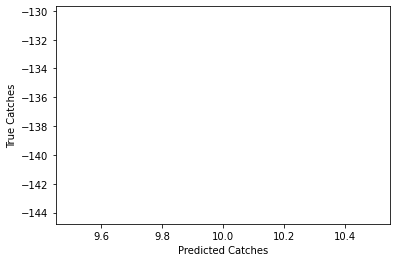

In [30]:
X_te_array = [10]

#y_te_pred = np.dot(X_te_array,w_te)

y_te_pred = np.matmul(X_te_array,w_te[0])
plt.plot(X_te_array, y_te_pred)
#plt.scatter([y_te_pred[:,0]], [y_te[:,0]])
plt.xlabel('Predicted Catches')
plt.ylabel('True Catches')

e) This data is count data. Count data has only positive values and also the distribution is discrete. You cannot catch 0.5 fish and that the CPD has probability density > 0 on negative number of fish is wrong too. A Gaussian as a CPD is therefore not ideal. 

Now use a Poissonian as CPD. If we assume a Poissonian then the probability to catch $k$ fish is given by 
$$
  p(k) = \exp(-\mu) \frac{\mu^k}{k!}
$$

and the NLL is thus by:

$$
 log(p(k)) = -\mu  + k \cdot \log(\mu) - log(k!)
$$

with $\mu$ being the expectation. In our case the average number of fish expected.

In the case of the probabilistic interpretation of the linear regression, $y_i$ for a given $x_i$ is distributed like a Gaussian. The paramter $\mu_i$ from $N(\mu_i,\sigma^2)$ has been determined from $x_i$ via $\mu_i= \beta^T \cdot x_i$ by minimizing the NLL. 

A small additional detail: For the Poissonian case, $\mu_i$ needs to be positive. We therefore do not use $\beta^T \cdot x_i$ directly but "pipe it through" an exponential first to make it positive and thus link $\mu_i=exp(\beta^T \cdot x_i)$ to the data.

Use a gradient descent approach on the NLL to find the solution for the parameters. Calculate the RMSE and the NLL on the test set and compare with c).

Hint: On the trainingset for the parameter values (1,1,1,1,1) the NLL should be approx 1508 and the gradient (1518.61, 1403.99, 1171.02, 5701.91, 3258.7). For the NLL a good learning rate would be 0.001 and training should be done for at least 5000 epochs.

f) Do the same plot as in d) but this time with a Poisson CPD. Hint you can use scipy.stats.poisson to calculate the percentiles.